<a href="https://colab.research.google.com/github/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/Bootcamp_DataScience_projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto Final de Conclusão de Curso
###Bootcamp Data Science Aplicada 2 by [Alura](https://www.alura.com.br/) 
####Autor: Helton Cordeiro
e-mail: heltoncordeiro@gmail.com


---

# **Objetivo desse notebook**

Após os dados disponibilizados pelo Hospital Sírio Libânes ter sido tratados no [notebook específico próprio](https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/projeto_final_tratamento_dados.ipynb)

Vamos começar a trabalhar com os Modelos de Machine Learning com o objetivo de 
#### **Prever** quais pacientes precisarão ser admitidos(as) na UTI e com isso **definir** qual a necessidade de leitos de UTI do hospital, a partir dos dados clínicos individuais disponíveis.

---


---


* RESUMO

Ideia do trabalho e principais resultados

* INTRODUÇÃO

Introdução sobre o problema (Kaggle) mas com suas palavras.


* Organização

Estrutura, seção de funções, seção de imports bem documentada. O projeto é para ficar no portfolio e para que outras pessoas possam aprender.

* Sequência lógica e linha de raciocínio desenvolvida



---



## Entendendo o Problema e Iniciando no Kaggle



[Kaggle](https://www.kaggle.com) 
* Crie uma conta e conheça o ambiente do Kaggle, permite também a criação de notebooks.

Fonte de Dados para estudo

url: https://www.kaggle.com/S%C3%ADrio-Libanes/covid19




##Importação de bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.simplefilter(action='ignore')

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.linear_model import LogisticRegressionCV

### Importando as funções auxiliares

* Arquivo funcoes.py contém as funções python que serão utilizados pelo projeto.

In [ ]:
# !python funcoes.py
from funcoes import roda_n_modelos, roda_modelo_cv

## Configurações iniciais

In [ ]:
pd.options.display.float_format = "{:,.6f}".format
sns.set()
sns.set_style("ticks")

mpl.rcParams['figure.figsize']= (16,8)
mpl.rcParams['figure.titlesize']= 18
mpl.rcParams['figure.titleweight']= 'bold'
mpl.rcParams['axes.labelsize']= 16
mpl.rcParams['axes.titlesize']= 18
mpl.rcParams['axes.titleweight']= 'bold'
mpl.rcParams['xtick.labelsize']= 11
mpl.rcParams['ytick.labelsize']= 11
mpl.rcParams['legend.fontsize']= 'large'
mpl.rcParams['date.autoformatter.day']= '%d/%m/%Y'
mpl.rcParams['grid.color']='grey'
mpl.rcParams['grid.linestyle']= '--'
mpl.rcParams['grid.linewidth']= 0.5

## Carregando os dados
Vamos carregar o arquivo de dados tratados e sem as colunas com alta correção.

O processo de tratamento dos dados estão nesse notebook [projeto_final_tratamento_dados.ipynb](https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/projeto_final_tratamento_dados.ipynb).


### Realizando a carga de dados

In [ ]:
url='https://github.com/hc0rd31r0/Bootcamp_Data_Science/blob/main/projeto-final/dados/Kaggle_Sirio_Libanes_ICU_Prediction-tratado-sem-corr.xls?raw=true'
dados_raw = pd.read_excel(url, index_col=0)

### Informações sobre a base de dados

In [ ]:
print(40*"---")
print("Nosso dataframe tem %s linhas e %s colunas\n" %(dados_raw.shape[0], dados_raw.shape[1]))
print(40*"---")
print("Distribuição do ICU\n%s\n" %(dados_raw['ICU'].value_counts(normalize=True)))
print(40*"---")
dados_raw.info(verbose=False)
print(40*"---")
display(dados_raw.head())

------------------------------------------------------------------------------------------------------------------------
Nosso dataframe tem 294 linhas e 95 colunas

------------------------------------------------------------------------------------------------------------------------
Distribuição do ICU
0   0.642857
1   0.357143
Name: ICU, dtype: float64

------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 294 entries, 0 to 293
Columns: 95 entries, AGE_ABOVE65 to ICU
dtypes: float64(46), int64(49)
memory usage: 220.5 KB
------------------------------------------------------------------------------------------------------------------------


,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_MEDIAN,...,PCR_MEDIAN,PCR_DIFF,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,OXYGEN_SATURATION_MIN,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU
0,1,6,0,0,0,0,0,1,1,0,0,1,0.605263,-1,-1.000000,-1,-1.000000,-1,-0.317073,-1,-0.317073,-1,-0.938950,-1,-1.000000,-1,0.183673,-1,-0.868365,-1,-0.742004,-1,-0.945093,-1,-0.891993,-1,0.090147,-1,-1,-0.932246,...,-0.875236,-1,-1,0.363636,-1,-0.540721,-1,-0.518519,-1,-1,0.345679,-1,-0.028571,-1,-0.997201,-1,-0.990854,-1,-0.825613,-1,-0.836145,-1,-0.994912,-1,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.898990,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,0,1,0,0,0,0,0,0,0,0,0,1,0.605263,-1,-1.000000,-1,-1.000000,-1,-0.317073,-1,-0.317073,-1,-0.938950,-1,-1.000000,-1,0.357143,-1,-0.912243,-1,-0.742004,-1,-0.958528,-1,-0.780261,-1,0.144654,-1,-1,-0.959849,...,-0.939887,-1,-1,0.363636,-1,-0.399199,-1,-0.703704,-1,-1,0.345679,-1,0.085714,-1,-0.995428,-1,-0.986662,-1,-0.846633,-1,-0.836145,-1,-0.978029,-1,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,0.959596,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,1
2,0,4,1,0,0,0,0,0,0,0,1,1,-0.263158,-1,-1.000000,-1,-1.000000,-1,-0.317073,-1,-0.317073,-1,-0.972789,-1,-1.000000,-1,0.326531,-1,-0.968861,-1,-0.194030,-1,-0.316589,-1,-0.891993,-1,-0.203354,-1,-1,-0.959849,...,-0.503592,-1,-1,0.363636,-1,-0.564753,-1,-0.777778,-1,-1,0.580247,-1,0.200000,-1,-0.989549,-1,-0.956555,-1,-0.846633,-1,-0.937349,-1,-0.978029,-1,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.878788,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,0,1,0,0,0,0,0,0,0,0,0,1,0.605263,-1,-1.000000,-1,-1.000000,-1,-0.317073,-1,-0.317073,-1,-0.935113,-1,-1.000000,-1,0.357143,-1,-0.913659,-1,-0.829424,-1,-0.938084,-1,-0.851024,-1,0.358491,-1,-1,-0.959849,...,-0.990926,-1,-1,0.363636,-1,-0.457944,-1,-0.592593,-1,-1,0.345679,-1,0.142857,-1,-0.998507,-1,-0.991235,-1,-0.846633,-1,-0.903614,-1,-1.000000,-1,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.939394,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0
4,0,1,0,0,0,0,0,0,0,0,0,1,0.605263,-1,-1.000000,-1,-1.000000,-1,-0.317073,-1,-0.317073,-1,-0.938950,-1,-1.000000,-1,0.357143,-1,-0.891012,-1,-0.742004,-1,-0.958528,-1,-0.891993,-1,0.291405,-1,-1,-0.959849,...,-0.997732,-1,-1,0.363636,-1,-0.292390,-1,-0.666667,-1,-1,0.345679,-1,0.085714,-1,-0.997947,-1,-0.988948,-1,-0.846633,-1,-0.884337,-1,-1.000000,-1,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,0.919192,0.842105,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0




---


#Modelos de Machine Learning
Relação dos Modelos que serão testados nesse projeto, foram selecionados por resolverem problemas de classificação binária e aprendizado supervisionado.


1. [KNeighborsClassifier](
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

2. [SVC - Linear](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

3. [SVC - RBF](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

4. [GaussianProcessClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html)

5. [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

6. [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

7. [Neural Net](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

8. [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

9. [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

10. [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)



---



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
# from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

names = ["K Neighbors", "Linear SVC", "RBF SVC", "Gaussian",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "GBC", "ExtraTrees"]

classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(gamma='auto'),
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    ExtraTreesClassifier() ]

In [ ]:
trained_models = pd.DataFrame()

for name, clf in zip(names, classifiers):
    results = roda_modelo_cv(clf, dados_raw, 5, 10)
    mean_results = {}
    for x in results:
        mean_results[x] = np.mean(results[x])

    df_result = pd.DataFrame([[name, clf, mean_results['test_accuracy'], mean_results['test_roc_auc'], mean_results['test_average_precision']]],
                            columns=['Nome', 'Modelo', 'Accuracy', 'ROC_auc','PR AUC'])
    
    trained_models = trained_models.append(df_result)

trained_models.reset_index(drop=True, inplace=True)

In [ ]:
trained_models.sort_values(by='ROC_auc', ascending=False)

,Nome,Modelo,Accuracy,ROC_auc,PR AUC
5,Random Forest,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.709246,0.762094,0.643153
6,Neural Net,"MLPClassifier(activation='relu', alpha=1, batc...",0.687411,0.745468,0.599260
1,Linear SVC,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.708521,0.740061,0.635958
8,GBC,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.708942,0.739006,0.621846
9,ExtraTrees,"ExtraTreesClassifier(bootstrap=False, ccp_alph...",0.679305,0.734527,0.599709
2,RBF SVC,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.641788,0.727008,0.577283
3,Gaussian,"GaussianProcessClassifier(copy_X_train=True, k...",0.627855,0.704808,0.504807
7,AdaBoost,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",0.664307,0.674131,0.569090
0,K Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.642835,0.658752,0.482376
4,Decision Tree,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.654436,0.623366,0.446150


busca.best_score_

Agora temos um conjunto para teste, vamos utilizar o RandomizedSearchCV para hiperparâmetros para melhorar o ajuste de nossos modelos.

In [ ]:
from scipy.stats import randint

hiperparams = { 
  "KNeighborsClassifier" : {
    "n_neighbors" : randint( 2, 20),
    "weights" : ['uniform', 'distance'],
    "leaf_size" : randint(25, 100),
    "metric" : ['minkowski','wminkowski','euclidean'] },
  "SVC_Linear" : {
    "kernel" : "linear",
    "gamma" : ["scale","auto"],
    "probabilitybool" : [True, False],
    "random_state" : 432432 }
}

In [ ]:
hiperparams["KNeighborsClassifier"]

{'leaf_size': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fcc21c9fa90>,
 'metric': ['minkowski', 'wminkowski', 'euclidean'],
 'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fcc21c9fa50>,
 'weights': ['uniform', 'distance']}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def roda_modelo_RandomizedSearchCV(modelo, dados, n_splits, n_repeats, espaco_de_parametros, n_iter):

    np.random.seed(1231234)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU"], axis=1)


    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)

    busca = RandomizedSearchCV(modelo, param_distributions=espaco_de_parametros,
                               n_iter = n_iter, cv = cv, 
                               scoring=['accuracy','roc_auc', 'precision', 'recall', 'f1', 'average_precision'],
                               return_train_score=True )
    busca.fit(x, y)

    resultados = pd.DataFrame(busca.cv_results_)

    auc_medio = resultados.iloc[busca.best_index_]['mean_test_score']
    auc_medio_treino = resultados.iloc[busca.best_index_]['mean_train_score']
    auc_std = resultados.iloc[busca.best_index_]['std_test_score']
    print(f'AUC  {auc_medio} - {auc_medio_treino}')
    
    return busca

In [ ]:


espaco_parametros_et = {
    "n_estimators" : randint(25, 250),
    "criterion" : ["gini", "entropy"],
    "max_depth" : randint(0, 15),
    "min_samples_split" : randint(0, 129),
    "min_samples_leaf" : randint(0, 129),
    "bootstrap" : [True, False],
    "warm_start" : [True, False] }

In [ ]:
busca = roda_modelo_RandomizedSearchCV( trained_models.at[9,'Modelo'], dados_raw, 5, 10, espaco_parametros_et, 10)

ValueError: ignored

In [ ]:
busca.best_params_

In [ ]:
busca.best_index_

In [ ]:
mean_results = {}
for x in results:
    mean_results[x] = np.mean(results[x])

df_result = pd.DataFrame([[name, clf, mean_results['test_accuracy'], mean_results['test_precision'],
                           mean_results['test_recall'], mean_results['test_roc_auc'], mean_results['test_f1']]], 
                          columns=['Nome', 'Modelo', 'Accuracy', 'Precision', 'Recall', 'ROC_auc','F1'])


In [ ]:
trained_models.at[4,'Modelo']

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split" : [32, 64, 128],
    "min_samples_leaf" : [32, 64, 128],
    "criterion" : ["gini", "entropy"]
}

roda_modelo_GridSearchCV(trained_models.at[4,'Modelo'], dados_raw, 5, 10, espaco_de_parametros)

AUC  0.7237089344984082 - 0.8086915602333649


(0.7237089344984082, 0.8086915602333649)

In [ ]:
from scipy.stats import randint

espaco_de_parametros = {
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "criterion" : ["gini", "entropy"]
}

roda_modelo_RandomizedSearchCV(trained_models.at[4,'Modelo'], dados_raw, 5, 10, espaco_de_parametros, 5)

AUC  0.7073132154711103 - 0.7867197069660906


(0.7073132154711103, 0.7867197069660906)

In [ ]:
espaco_de_parametros = {
    "n_estimators" :randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split" : randint(32, 129),
    "min_samples_leaf" : randint(32, 129),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

roda_modelo_RandomizedSearchCV(trained_models.at[5,'Modelo'], dados_raw, 5, 10, espaco_de_parametros, 5)

AUC  0.7652983810878549 - 0.8594338910189383


(0.7652983810878549, 0.8594338910189383)

##DummyClassifier

O modelo mais simples de classificação.

In [ ]:
from sklearn.metrics  import accuracy_score, auc, roc_curve, precision_recall_curve, roc_auc_score, precision_score, recall_score, average_precision_score
import plotly.express as px

In [ ]:
def evaluate(model, testing_set_x, testing_set_y):
    predictions = model.predict_proba(testing_set_x)
    
    accuracy  = accuracy_score(testing_set_y, predictions[:,1] >= 0.5)
    roc_auc   = roc_auc_score(testing_set_y, predictions[:,1])
    precision = precision_score(testing_set_y, predictions[:,1] >= 0.5)
    recall    = recall_score(testing_set_y, predictions[:,1] >= 0.5)
    pr_auc    = average_precision_score(testing_set_y, predictions[:,1])
    
    result = pd.DataFrame([[accuracy, precision, recall, roc_auc, pr_auc]], columns=['Accuracy', 'Precision', 'Recall', 'ROC_auc','PR_auc'])
    print(classification_report(testing_set_y, predictions[:,1]))
    plot_confusion_matrix(model, testing_set_x, testing_set_y)

    return(result)

In [ ]:
x_columns = dados_raw.columns[:-1]
x = dados_raw[x_columns] # Entrada
y = dados_raw['ICU'] # saida

np.random.seed(73246)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

              precision    recall  f1-score   support

           0       0.72      0.65      0.68        48
           1       0.45      0.54      0.49        26

    accuracy                           0.61        74
   macro avg       0.59      0.59      0.59        74
weighted avg       0.63      0.61      0.61        74



,Accuracy,Precision,Recall,ROC_auc,PR_auc
0,0.540541,0.366667,0.423077,0.513622,0.357831


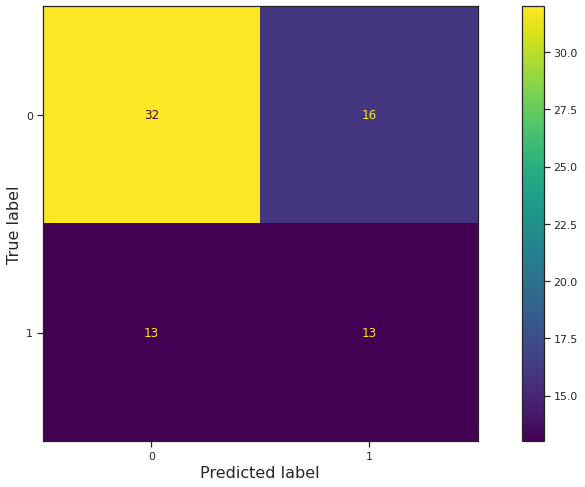

In [ ]:
modelo_dummy = DummyClassifier()
modelo_dummy.fit(x_train, y_train)

evaluate(modelo_dummy, x_test, y_test)

In [ ]:
 predicao = modelo_dummy.predict(x_test)
 prob_predic = modelo_dummy.predict_proba(x_test)

In [ ]:
predicao

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0])

In [ ]:
prob_predic[:,1] >= 0.5

array([False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False,  True,  True, False,
       False, False,  True, False,  True, False, False, False, False,
        True, False, False, False,  True, False,  True, False, False,
       False,  True, False,  True, False, False, False, False, False,
        True, False,  True, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
       False, False])

In [ ]:
modelo = LogisticRegression(max_iter=2000)
modelo_arvore = DecisionTreeClassifier()
modelo_logregCV = LogisticRegressionCV(max_iter=10000)
modelo_random_arvore = RandomForestClassifier(max_depth=i)

In [ ]:
plot_confusion_matrix(modelo_arvore, x_test, y_test)
print(classification_report(y_test, predicao_arvore))
cross_validate( modelo_logreg, x, y, cv=3)

In [ ]:
def plot_confusion_matrix_for_models(names, classifiers, nrows, ncols):
    np.random.seed(73246)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 16))
    axis = []
    for ax in axes:
        axis.extend(ax)
    axes_ind = 0
    trained_models = []
    for name, clf in zip(names, classifiers):
        clf.fit(x_train, y_train)
        trained_models.append(clf)
        disp = plot_confusion_matrix(clf, x_test, y_test, ax=axis[axes_ind])
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
        results = cross_validate(clf, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
        auc_medio = np.mean(results['test_score'])
        axis[axes_ind].set_title(f'{name}, AUC = {auc_medio:.3f}')
        disp.im_.set_clim(0, 50)
        axes_ind += 1
    plt.show()
    for ax in axis[len(names):]:
        ax.set_visible(False)
        fig.delaxes(ax)
    return trained_models


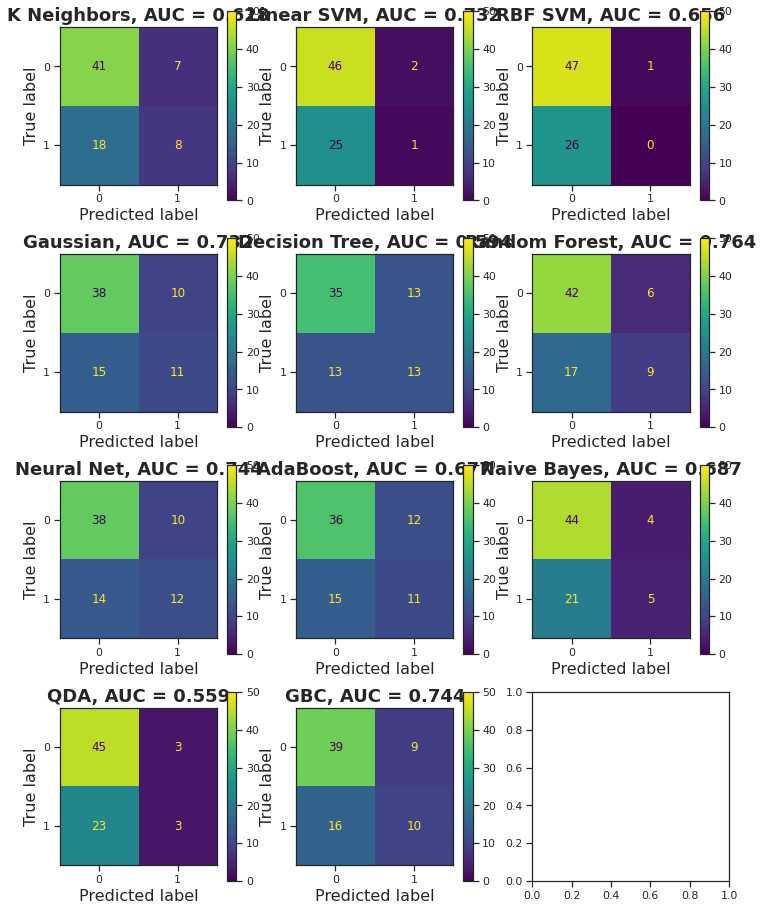

[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                      weights='uniform'),
 SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
     probability=False, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 GaussianProcessClassifier(copy_X_train=True, kernel=1**2 * RBF(length_scale=1),
                           max_iter_predict=100, multi_class='one_vs_rest',
                           n_jobs=None, n_restarts_optimizer=0,
                           optimizer='fmin_l_bfgs_b', random_state=None,
        

In [ ]:
plot_confusion_matrix_for_models(names, classifiers, 4, 3)

In [ ]:
dados_temp = dados_raw.sample(frac=1).reset_index(drop=True)

x_columns = dados_temp.columns
y = dados_temp['ICU']
x = dados_temp[x_columns].drop(["ICU"], axis=1)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

In [ ]:
modelo_arvore = RandomForestClassifier(n_estimators=100, max_depth=3)
resultados = cross_validate(modelo_arvore, x, y, cv=cv, scoring=['accuracy','roc_auc', 'precision', 'recall', 'average_precision'], return_train_score=True)

In [ ]:
resultados2 = cross_validate(modelo_arvore, x, y, cv=cv, scoring='roc_auc', return_train_score=True)

# Salvando nosso modelo

### pickle (https://docs.python.org/3/library/pickle.html)

<p style='font-size: 20px; line-height: 2; margin: 10px 50px; text-align: justify;'>O módulo <b>pickle</b> implementa protocolos binários para serializar e desserializar a estrutura de um objeto Python.</p>


In [ ]:
import pickle

In [ ]:
output = open('/content/modelo_hsl', 'wb')
pickle.dump(modelo, output)
output.close()

# Conclusão

---



## Sugestão de Estudo

* Desenvolver um modelo para analisar os casos de óbitos e aplicar o modelo desenvolvido nas cidades do Estado.

# Referências


https://docs.microsoft.com/pt-br/azure/machine-learning/how-to-understand-automated-ml

https://docs.microsoft.com/pt-br/azure/machine-learning/how-to-configure-auto-train

https://medium.com/data-hackers/matriz-de-confus%C3%A3o-e-auc-roc-f7e446dca107
